In [8]:
import gc
import io
import os
import time

import numpy as np
import tensorflow as tf
import tensorflow_gan as tfgan
import logging
# Keep the import below for registering all model definitions
from models import ddpm
import losses
import sampling
from models import utils as mutils
from models.ema import ExponentialMovingAverage
import datasets
import evaluation
import likelihood
import sde_lib
from absl import flags
import torch
from torch.utils import tensorboard
from torchvision.utils import make_grid, save_image
from utils import save_checkpoint, restore_checkpoint
from configs.vp import cifar10_ddpm_continuous as configs
from sde_lib import VESDE, VPSDE, subVPSDE

In [9]:
workdir = "experiments/dpm_data"
eval_folder="eval"
eval_dir = os.path.join(workdir, eval_folder)
tf.io.gfile.makedirs(eval_folder)
config=configs.get_config()
config.eval.batch_size = 16
sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3
# Build data pipeline
train_ds, eval_ds, _ = datasets.get_dataset(config,
                                            uniform_dequantization=config.data.uniform_dequantization,
                                            evaluation=True)

# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

In [10]:
score_model = mutils.create_model(config)
optimizer = losses.get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=score_model, ema=ema, step=0)

checkpoint_dir = os.path.join(workdir, "checkpoints")

sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3


In [11]:
sampling_shape = (config.eval.batch_size,
                      config.data.num_channels,
                      config.data.image_size, config.data.image_size)
eval_iter = iter(eval_ds)

In [12]:
batch = torch.from_numpy(next(eval_iter)['image']._numpy()).to(config.device).float()
batch = batch.permute(0, 3, 1, 2)
batch = scaler(batch)
lst_steps=torch.tensor([0.050950001925230026])
t = lst_steps.to(batch.device).repeat(batch.shape[0])
z = torch.randn_like(batch)
mean, std = sde.marginal_prob(batch, t)
perturbed_data = mean + std[:, None, None, None] * z

In [13]:
ckpt = 1
ckpt_path = os.path.join(checkpoint_dir, f'checkpoint_{ckpt}.pth')
state = restore_checkpoint(ckpt_path, state, device=config.device)
ema.copy_to(score_model.parameters())

In [14]:
output = score_model(perturbed_data,t)

In [15]:
import matplotlib.pyplot as plt
def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img
def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  #x = x.detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

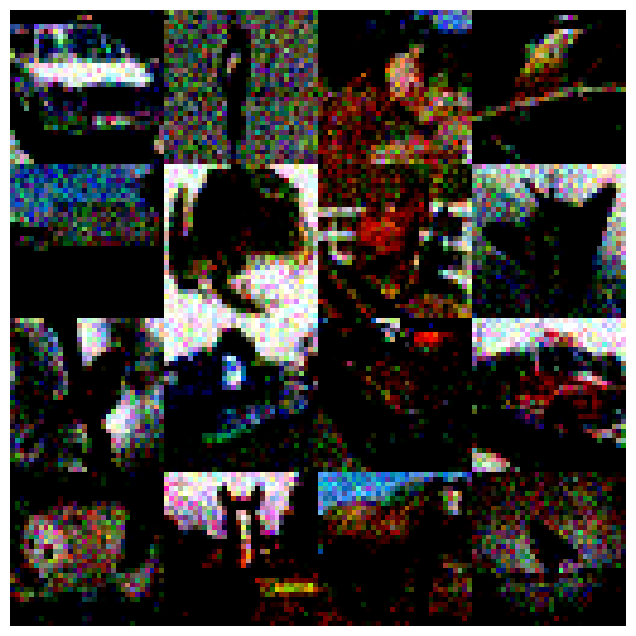

In [16]:
show_samples(perturbed_data)

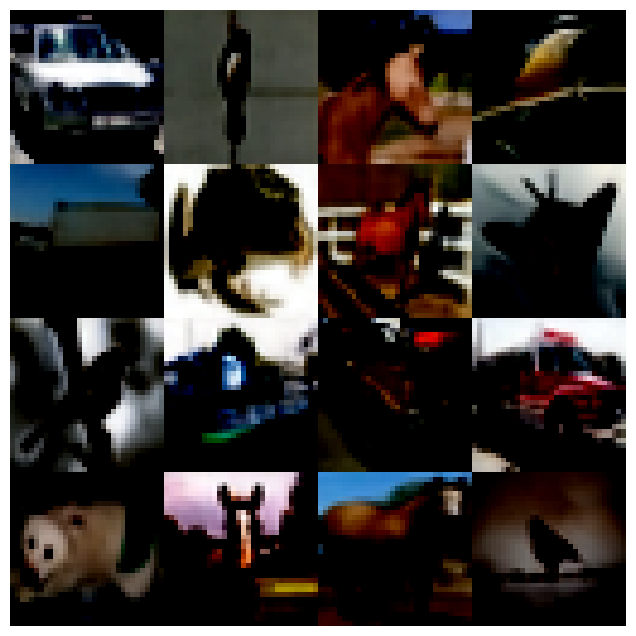

In [17]:
show_samples(output)

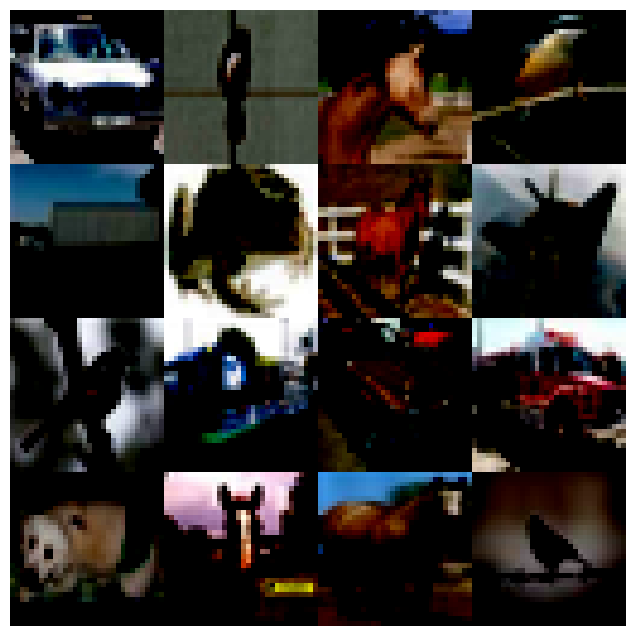

In [18]:
show_samples(batch)